<a href="https://colab.research.google.com/github/Sudharsan005P/Image_captioning_system/blob/main/trained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [ ]:
image_path = os.path.join(path, "Images")

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'flickr8k' dataset.
Path to dataset files: /kaggle/input/flickr8k


In [ ]:
data = pd.read_csv("/content/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:15]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas 

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [ ]:
!ls /root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1/Flickr8k_Dataset


ls: cannot access '/root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1/Flickr8k_Dataset': No such file or directory


In [ ]:
!ls /root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1

flickr30k_images


In [12]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [40:39<00:00,  3.32it/s]


In [13]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [14]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [15]:
from tensorflow.keras.utils import plot_model

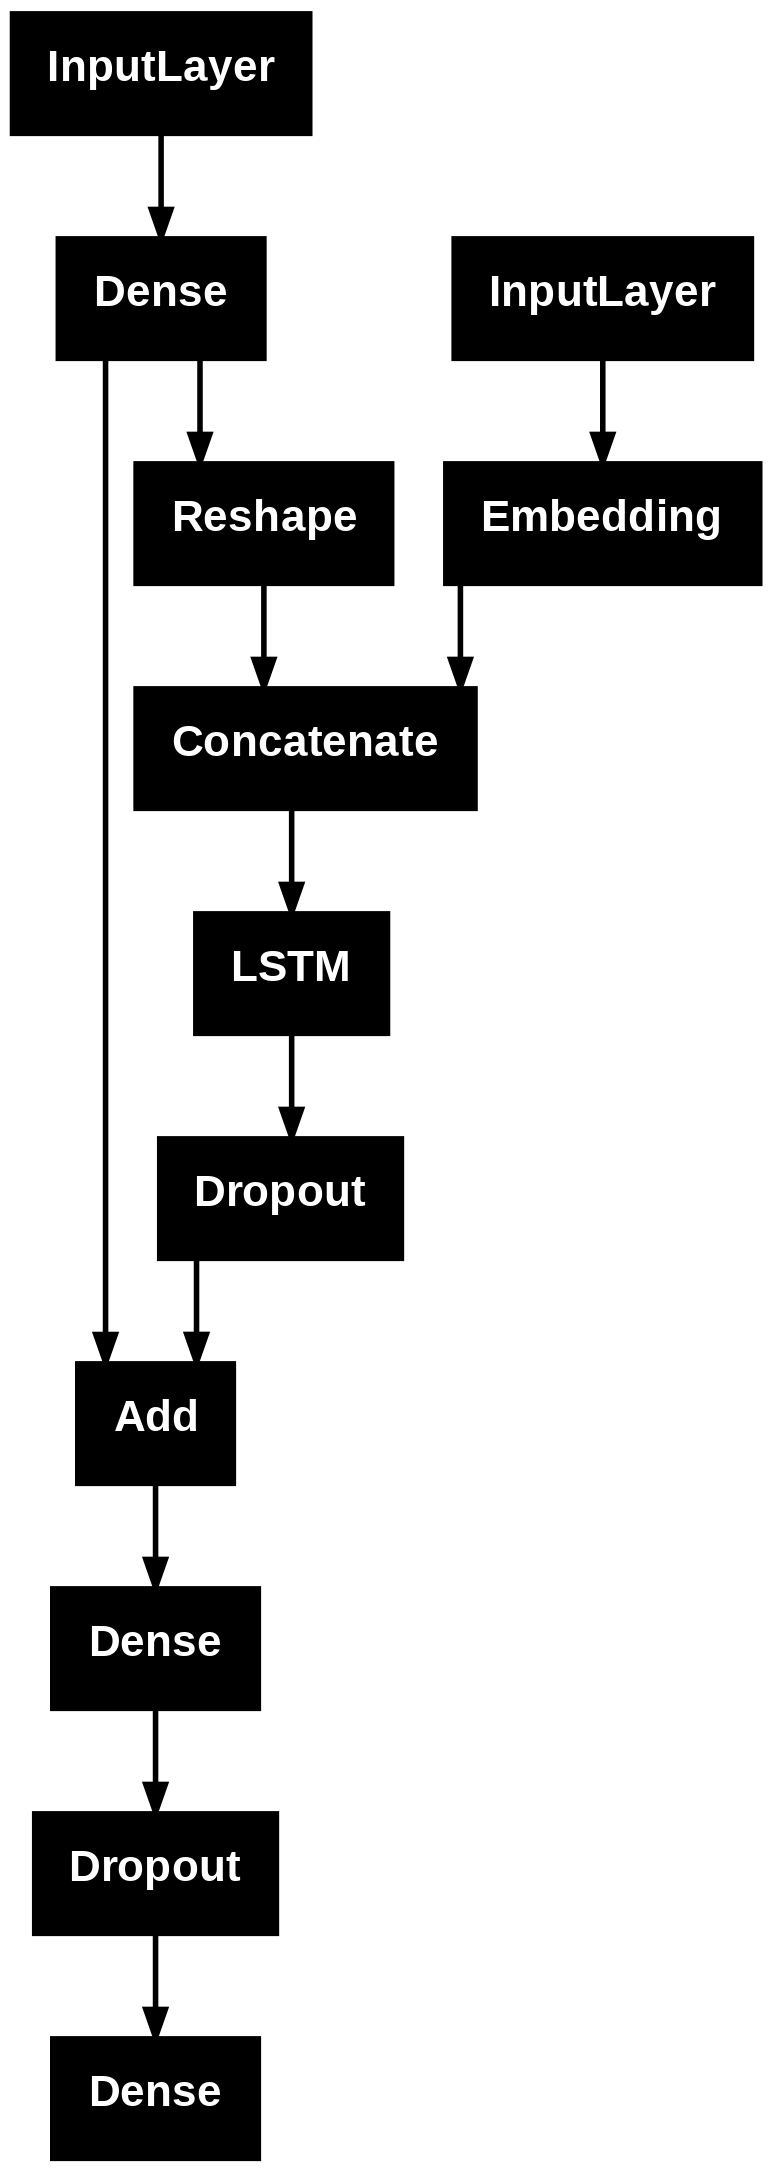

In [16]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,122,240 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 35, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8290)      │  1,069,410 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,241,634 (16.18 MB)

 Trainable params: 4,241,634 (16.18 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [18]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [19]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5.7168
Epoch 1: val_loss improved from inf to 4.28897, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 763s 1s/step - loss: 5.7157 - val_loss: 4.2890 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.3648
Epoch 2: val_loss improved from 4.28897 to 3.98461, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 751s 1s/step - loss: 4.3646 - val_loss: 3.9846 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.0527
Epoch 3: val_loss improved from 3.98461 to 3.82660, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 754s 1s/step - loss: 4.0526 - val_loss: 3.8266 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.8506
Epoch 4: val_loss improved from 3.82660 to 3.74375, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 763s 1s/step - loss: 3.8506 - val_loss: 3.7438 - learning_rate: 0.0010
Epoch 5/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.7253
Epoch 5: val_loss improved from 3.74375 to 3.69002, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 787s 1s/step - loss: 3.7253 - val_loss: 3.6900 - learning_rate: 0.0010
Epoch 6/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.6278
Epoch 6: val_loss improved from 3.69002 to 3.65738, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 783s 1s/step - loss: 3.6278 - val_loss: 3.6574 - learning_rate: 0.0010
Epoch 7/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.5422
Epoch 7: val_loss improved from 3.65738 to 3.64124, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 756s 1s/step - loss: 3.5422 - val_loss: 3.6412 - learning_rate: 0.0010
Epoch 8/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.4708
Epoch 8: val_loss improved from 3.64124 to 3.62515, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 785s 1s/step - loss: 3.4708 - val_loss: 3.6252 - learning_rate: 0.0010
Epoch 9/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.4083
Epoch 9: val_loss did not improve from 3.62515
537/537 ━━━━━━━━━━━━━━━━━━━━ 783s 1s/step - loss: 3.4083 - val_loss: 3.6265 - learning_rate: 0.0010
Epoch 10/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.3534
Epoch 10: val_loss did not improve from 3.62515
537/537 ━━━━━━━━━━━━━━━━━━━━ 804s 1s/step - loss: 3.3534 - val_loss: 3.6395 - learning_rate: 0.0010
Epoch 11/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.3111
Epoch 11: val_loss did not improve from 3.62515

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
537/537 ━━━━━━━━━━━━━━━━━━━━ 785s 1s/step - loss: 3.3111 - val_loss: 3.6537 - learning_rate: 0.0010
Epoch 12/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.2169
Epoch 12: val_loss did not improve from 3.62515
537/537 ━━━━━━━━━━━━━━━━━━━━ 749s 1s/step - loss: 3.2169 - val_